In [1]:
import numpy as np
import supervillain as sv
from supervillain.h5 import H5able
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler
import matplotlib.colors as colors
from tqdm.notebook import tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
L = sv.lattice.Lattice2D(5)
S = sv.action.Worldline(L,0.5)

In [4]:
W = sv.generator.worms.UndirectedWorm(S,1)

## Single step proof of concept

Propositions: 2
Length: 0.0


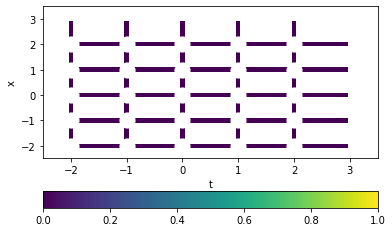

In [5]:
fig, ax = plt.subplots(1,1)
startpoint = np.array([0,0])
endpoint = startpoint + np.array([1,1])
currentpoint = startpoint.copy()
configlist = []
propositions=0
currentconfig = L.form(1)
initconfig = currentconfig.copy()
length = 0
probslist = []
while (endpoint != startpoint).any():
    newconfig, endpoint, probs = W.burrow(currentconfig, currentpoint)
    currentpoint = endpoint.copy()
    currentconfig = newconfig.copy()
    configlist.append(currentconfig)
    propositions += 1
length = np.sum(np.abs(currentconfig-initconfig))
print(f'Propositions: {propositions}')
print(f'Length: {length}')
L.plot_form(1,currentconfig,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [6]:
S.valid(newconfig)

True

In [7]:
newconfig

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [8]:
probs

[0.17487770452710943,
 0.17487770452710943,
 0.4753668864186717,
 0.17487770452710943]

# Ensemble generation
Currently stalls, and so I have it throw an error if a worm reaches 1000 propositions

In [9]:
L = sv.lattice.Lattice2D(5)
S = sv.action.Worldline(L,0.5)
W = sv.generator.worms.UndirectedWorm(S,1)
ensemble = sv.ensemble.Ensemble(S)
ensemble = ensemble.generate(1000,W,progress = tqdm)

  0%|          | 0/999 [00:00<?, ?it/s]

Here we plot the change in the last 50 configurations top to bottom to show the stalling behavior of the worm. Beware colors in plotting can behave strangely if the range is restricted

In [10]:
len(W.startpointlist)

1000

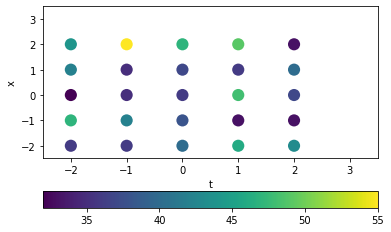

In [11]:
fig, ax = plt.subplots(1,1)
W.startpointlist
blank = L.form(0)
for point in W.startpointlist:
    blank[point[0],point[1]]+=1
L.plot_form(0,blank,ax)
fig.colorbar(ax.get_children()[0], ax=ax, orientation='horizontal')
    # blank[point[0],point[1]] = 1


In [12]:
W.endconfiglist

[array([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]]),
 array([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]]),
 array([[[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [-1,  0,  1,  0,  0],
         [ 0,  0, -1,  1,  0],
         [ 0,  0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [ 1,  1,  0,  0,  0],
         [-1, -1,  1,  0,  0],
         [ 0,  0, -1,  0,  0]]]),
 array([[[ 0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0],
         [-1,  0,  1,  0,  0],
         [ 0,  0, -1,  1,  0],
         [ 0,  0,  0,  0,  0

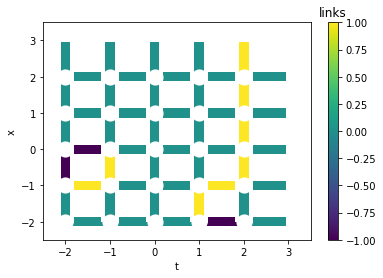

In [13]:
fig,ax = plt.subplots(1,1)
configs = W.endconfiglist
j = 16
colors
L.plot_form(1,configs[j],ax,label = 'links',linkwidth = .05)

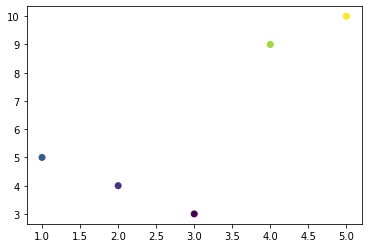

In [14]:
x = [1,2,3,4,5]
y = [5,4,3,9,10]
plt.scatter(x,y,c = y, norm = None)

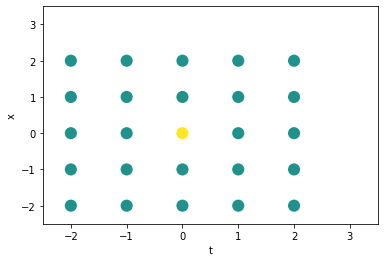

In [23]:
norm = colors.CenteredNorm()
plot = L.form(0)
plot[0,0]=1
fig,ax = plt.subplots(1,1)
L.plot_form(0,plot,ax, norm = norm)

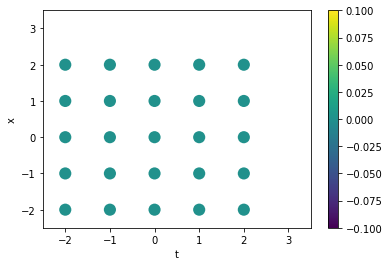

In [19]:
counter = L.form(0)
j = -400
a = np.array(W.lastsiteslist[j:j+50])
for el in a:
    counter[el[0],el[1]] +=1
fig, ax = plt.subplots(1,1)
L.plot_form(0,counter,ax)
fig.colorbar(ax.get_children()[0])

In [20]:
W.lastconfigslist[-400]
L.delta(1,W.lastconfigslist[-400])

IndexError: list index out of range

In [ ]:
W.lastconfigslist[-1]

In [ ]:
counter

In [ ]:
print(ct)

In [ ]:
np.unique(W.lastsiteslist[:-50])

In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(1,W.lastconfigslist[991]-W.endconfiglist[-1],ax)

In [ ]:
W.lastconfigslist[2]-W.endconfiglist[-1]

In [ ]:
W.lastconfigslist[0]


In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(0,W.startpointlist[-1],ax)

In [ ]:
fig, ax = plt.subplots(50,1, figsize = (50,300))
for j in range(50):
    config = W.lastconfigslist[-50+j]
    sites = W.lastsiteslist[-50+j]
    siteconfig = L.form(0)
    siteconfig[sites[0],sites[1]] += 1
    L.plot_form(1,config - W.lastconfigslist[-50+j-1],ax[j])
    L.plot_form(0,siteconfig,ax[j])
    ax[j].set_title(W.lastprobslist[-50+j])
fig.colorbar(ax[0].get_children()[1], ax=ax, orientation='horizontal')


# DEPRECATED:
Code I used to manually run propositions for the worm

In [ ]:
config2, end2, probs2 = W.burrow(L.plot_form(0),[0,0])
fig, ax = plt.subplots(1,1)
L.plot_form(1,config2,ax)
center = L.form(0)
center[0,0] = 1
center[end2[0],end2[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (10,20))
L.plot_form(1,L.form(1),ax[0])
L.plot_form(0,L.form(0),ax[0])
newconfig = W.step({'m':L.form(1)})
L.plot_form(1,newconfig['m'],ax[1])
L.plot_form(0,L.form(0),ax[1])

In [ ]:
fig, ax = plt.subplots(1,1)
L.plot_form(1,newconfig['m'],ax)


In [ ]:
config3, end3, probs3 = W.burrow(config2,end2)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config3,ax)
center = L.form(0)
center[0,0] = 1
center[end3[0],end3[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
config4, end4, probs4 = W.burrow(config3,end3)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config4,ax)
center = L.form(0)
center[0,0] = 1
center[end4[0],end4[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
config5, end5, probs5 = W.burrow(config4,end4)
fig, ax = plt.subplots(1,1)
L.plot_form(1,config5,ax)
center = L.form(0)
center[0,0] = 1
center[end5[0],end5[1]] = 1
L.plot_form(0,center,ax)
fig.colorbar(ax.get_children()[1], ax=ax, orientation='horizontal')

In [ ]:
print(probs2,sum(probs2))
print(probs3,sum(probs3))
print(probs4,sum(probs4))
print(probs5,sum(probs5))